java_data删除数据前： (2994, 10)
java_data删除数据后： (2952, 9)
<class 'pandas.core.series.Series'>
去重之前java_data的形状为： (2952, 11)
重复的记录所在的行为： Int64Index([ 133,  280,  307,  308,  321,  357,  359,  363,  370,  371,
            ...
            2922, 2928, 2929, 2930, 2931, 2932, 2933, 2936, 2950, 2951],
           dtype='int64', length=637)
去重之后java_data的形状为： (2315, 11)
java_data数据集中需要删除的列为： None


,min_wY,max_wY,min_salary,max_salary,companySize
count,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000
mean,2.927862,5.530022,19.688553,34.023758,1606.872570
std,1.641477,3.425252,7.210936,13.375594,1507.750315
min,0.000000,0.000000,3.000000,4.000000,8.000000
25%,3.000000,5.000000,15.000000,25.000000,100.000000
50%,3.000000,5.000000,20.000000,30.000000,1250.000000
75%,3.000000,5.000000,25.000000,40.000000,3500.000000
max,10.000000,30.000000,70.000000,105.000000,3500.000000


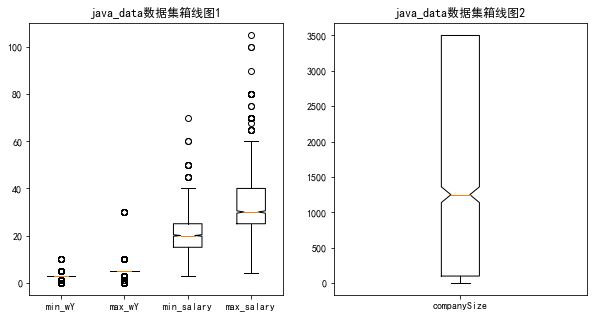

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import re
from wordcloud import WordCloud
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
plt.rcParams["font.sans-serif"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False
java_data = pd.read_csv('./lg_java.csv')
java_data = java_data.rename(columns={'公司全名':'companyFullName',
                                     '公司简称':'companyShortName',
                                     '公司规模':'companySize',
                                     '融资阶段':'financeStage',
                                     '区域':'district',
                                     '职位名称':'positionName',
                                     '工作经验':'workYear',
                                     '学历要求':'education',
                                     '工资':'salary',
                                     '职位福利':'positionAdvantage'})

#删除单位的函数
def delete(data):
    res = data
    if res == '不限':
        res = 0;
    elif res == '在校/应届':
        res = 0;
    else:
        if '人' in res:
            res = re.sub(r'人', '', res)
        if '以上' in res:
            res = re.sub(r'以上', '', res)
        if '以下' in res:
            res = re.sub(r'以下', '', res)
        if '年' in res:
            res = re.sub(r'年', '', res)
        if '少于' in res:
            res = re.sub(r'少于', '', res)
        if 'k' in res:
            res = re.sub(r'k', '', res)
    return res
#定义求取特征是否完全相同的矩阵的函数
def FeatureEquals(df): 
    dfEquals = pd.DataFrame([],columns=df.columns,index=df.columns)
    for i in df.columns:
        for j in df.columns:
            dfEquals.loc[i,j]=df.loc[:,i].equals(df.loc[:,j])
    return dfEquals
#获取完全重复的特征
def GetDupCol(data):
    detEquals = FeatureEquals(data)
    lenDet = detEquals.shape[0]
    dupCol = []
    for k in range(lenDet):
        for l in range(k + 1, lenDet):
            if detEquals.iloc[k, l] & (detEquals.columns[l] not in dupCol):
                dupCol.append(detEquals.columns[l])
####对于java_data数据集的操作#############################################################################################################
#1.数据格式统一
java_data['companySize'] = java_data['companySize'].map(lambda x : delete(x))
java_data['workYear'] = java_data['workYear'].map(lambda x : delete(x))
java_data['salary'] = java_data['salary'].map(lambda x : delete(x))
#清洗数据
print('java_data删除数据前：', java_data.shape)
java_data.drop(java_data[java_data['positionName'].str.contains('实习')].index, inplace = True)
java_data = java_data.reset_index(drop=True)
java_data = java_data.drop(["companyFullName"], axis=1)
print('java_data删除数据后：', java_data.shape)
#2.workYear列拆分
workYear = java_data['workYear']
min_wY = np.array(np.arange(len(workYear)), dtype = int)
max_wY = np.array(np.arange(len(workYear)), dtype = int)
print(type(workYear))
for i in workYear.index:
    if workYear[i] == 0:
        min_wY[i] = 0
        max_wY[i] = 0
    elif workYear[i] == '1':
        min_wY[i] = 0
        max_wY[i] = 1
    elif workYear[i] == '10':
        min_wY[i] = 10
        max_wY[i] = 30
    else:
        min_wY[i] = int(workYear[i].split('-', 1)[0])
        max_wY[i] = int(workYear[i].split('-', 1)[-1])
java_data['min_wY'] = min_wY
java_data['max_wY'] = max_wY
java_data = java_data.drop(["workYear"], axis=1)
#3.salary列拆分
salary = java_data['salary']
min_salary = np.array(np.arange(len(salary)), dtype = int)
max_salary = np.array(np.arange(len(salary)), dtype = int)
for i in salary.index:
    min_salary[i] = int(salary[i].split('-', 1)[0])
    max_salary[i] = int(salary[i].split('-', 1)[-1])
java_data['min_salary'] = min_salary
java_data['max_salary'] = max_salary
java_data = java_data.drop(["salary"], axis=1)
#3.companySize列拆分
companySize = java_data['companySize']
min_cS = np.array(np.arange(len(companySize)), dtype = int)
max_cS = np.array(np.arange(len(companySize)), dtype = int)
for i in companySize.index:
    if companySize[i] == '15':
        min_cS[i] = 1
        max_cS[i] = 15
    elif companySize[i] == '2000':
        min_cS[i] = 2000
        max_cS[i] = 5000
    else:
        min_cS[i] = float(companySize[i].split('-', 1)[0])
        max_cS[i] = float(companySize[i].split('-', 1)[-1])
java_data['min_cS'] = min_cS
java_data['max_cS'] = max_cS
java_data = java_data.drop(["companySize"], axis=1)
#合并两个cS
java_data['companySize'] = (java_data['min_cS'] + java_data['max_cS']) / 2
java_data = java_data.drop(['min_cS', 'max_cS'], axis = 1)
#查看缺失值
java_data.isnull().sum()
#查看重复值
print('去重之前java_data的形状为：', java_data.shape)
print('重复的记录所在的行为：', java_data[java_data.duplicated().values].index)
java_data = java_data.drop_duplicates()
java_data = java_data.reset_index(drop=True)
print('去重之后java_data的形状为：', java_data.shape)
dupCol1 = GetDupCol(java_data)
print('java_data数据集中需要删除的列为：', dupCol1)
java_numData1 = java_data[['min_wY', 'max_wY', 'min_salary', 'max_salary']]
java_numData2 = java_data[['companySize']]
p1 = plt.figure(figsize = (10, 5))
label1 = ['min_wY', 'max_wY', 'min_salary', 'max_salary']
label2 = ['companySize']
ax1 = p1.add_subplot(1, 2, 1)
ax2 = p1.add_subplot(1, 2, 2)
plt.sca(ax1)
plt.boxplot(java_numData1, notch = True, labels = label1, meanline = True)
plt.title("java_data数据集箱线图1")
plt.sca(ax2)
plt.boxplot(java_numData2, notch = True, labels = label2, meanline = True)
plt.title("java_data数据集箱线图2")
plt.savefig("java_data箱线图.png")
#描述性统计
java_data.describe()

python_data删除数据前： (681, 10)
python_data删除数据后： (660, 9)
去重之前python_data的形状为： (660, 11)
重复的记录所在的行为： Int64Index([ 17,  30, 104, 129, 189, 252, 297, 330, 353, 354, 355, 356, 360,
            361, 362, 363, 364, 367, 368, 369, 370, 371, 423, 425, 553, 559,
            566, 609, 610, 623, 624, 630, 631, 644],
           dtype='int64')
去重之后python_data的形状为： (626, 11)
python_data数据集中需要删除的列为： None


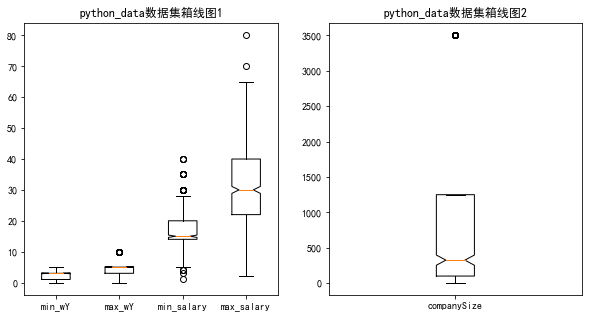

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
python_data = pd.read_csv('./lg_python.csv')
python_data = python_data.rename(columns={'公司全名':'companyFullName',
                                     '公司简称':'companyShortName',
                                     '公司规模':'companySize',
                                     '融资阶段':'financeStage',
                                     '区域':'district',
                                     '职位名称':'positionName',
                                     '工作经验':'workYear',
                                     '学历要求':'education',
                                     '工资':'salary',
                                     '职位福利':'positionAdvantage'})

#删除单位的函数
def delete(data):
    res = data
    if res == '不限':
        res = 0;
    elif res == '在校/应届':
        res = 0;
    else:
        if '人' in res:
            res = re.sub(r'人', '', res)
        if '以上' in res:
            res = re.sub(r'以上', '', res)
        if '以下' in res:
            res = re.sub(r'以下', '', res)
        if '年' in res:
            res = re.sub(r'年', '', res)
        if '少于' in res:
            res = re.sub(r'少于', '', res)
        if 'k' in res:
            res = re.sub(r'k', '', res)
    return res
#定义求取特征是否完全相同的矩阵的函数
def FeatureEquals(df): 
    dfEquals = pd.DataFrame([],columns=df.columns,index=df.columns)
    for i in df.columns:
        for j in df.columns:
            dfEquals.loc[i,j]=df.loc[:,i].equals(df.loc[:,j])
    return dfEquals
#获取完全重复的特征
def GetDupCol(data):
    detEquals = FeatureEquals(data)
    lenDet = detEquals.shape[0]
    dupCol = []
    for k in range(lenDet):
        for l in range(k + 1, lenDet):
            if detEquals.iloc[k, l] & (detEquals.columns[l] not in dupCol):
                dupCol.append(detEquals.columns[l])
####对于python_data数据集的操作#############################################################################################################1
#1.数据格式统一
python_data['companySize'] = python_data['companySize'].map(lambda x : delete(x))
python_data['workYear'] = python_data['workYear'].map(lambda x : delete(x))
python_data['salary'] = python_data['salary'].map(lambda x : delete(x))
#清洗数据
print('python_data删除数据前：', python_data.shape)
python_data.drop(python_data[python_data['positionName'].str.contains('实习')].index, inplace = True)
python_data = python_data.reset_index(drop=True)
python_data = python_data.drop(["companyFullName"], axis=1)
print('python_data删除数据后：', python_data.shape)
#2.workYear列拆分
workYear = python_data['workYear']
min_wY = np.array(np.arange(len(workYear)), dtype = int)
max_wY = np.array(np.arange(len(workYear)), dtype = int)
for i in workYear.index:
    if workYear[i] == 0:
        min_wY[i] = 0
        max_wY[i] = 0
    elif workYear[i] == '1':
        min_wY[i] = 0
        max_wY[i] = 1
    elif workYear[i] == '10':
        min_wY[i] = 10
        max_wY[i] = 30
    else:
        min_wY[i] = int(workYear[i].split('-', 1)[0])
        max_wY[i] = int(workYear[i].split('-', 1)[-1])
python_data['min_wY'] = min_wY
python_data['max_wY'] = max_wY
python_data = python_data.drop(["workYear"], axis=1)
#3.salary列拆分
salary = python_data['salary']
min_salary = np.array(np.arange(len(salary)), dtype = int)
max_salary = np.array(np.arange(len(salary)), dtype = int)
for i in salary.index:
    min_salary[i] = int(salary[i].split('-', 1)[0])
    max_salary[i] = int(salary[i].split('-', 1)[-1])
python_data['min_salary'] = min_salary
python_data['max_salary'] = max_salary
python_data = python_data.drop(["salary"], axis=1)
#3.companySize列拆分
companySize = python_data['companySize']
min_cS = np.array(np.arange(len(companySize)), dtype = int)
max_cS = np.array(np.arange(len(companySize)), dtype = int)
for i in companySize.index:
    if companySize[i] == '15':
        min_cS[i] = 1
        max_cS[i] = 15
    elif companySize[i] == '2000':
        min_cS[i] = 2000
        max_cS[i] = 5000
    else:
        min_cS[i] = int(companySize[i].split('-', 1)[0])
        max_cS[i] = int(companySize[i].split('-', 1)[-1])
python_data['min_cS'] = min_cS
python_data['max_cS'] = max_cS
python_data = python_data.drop(["companySize"], axis=1)
#合并两个cS
python_data['companySize'] = (python_data['min_cS'] + python_data['max_cS']) / 2
python_data = python_data.drop(['min_cS', 'max_cS'], axis = 1)
#查看缺失值
python_data.isnull().sum()
#查看重复值
print('去重之前python_data的形状为：', python_data.shape)
print('重复的记录所在的行为：', python_data[python_data.duplicated().values].index)
python_data = python_data.drop_duplicates()
python_data = python_data.reset_index(drop=True)
print('去重之后python_data的形状为：', python_data.shape)
dupCol2 = GetDupCol(python_data)
print('python_data数据集中需要删除的列为：', dupCol2)
python_numData1 = python_data[['min_wY', 'max_wY', 'min_salary', 'max_salary']]
python_numData2 = python_data[['companySize']]
p1 = plt.figure(figsize = (10, 5))
label1 = ['min_wY', 'max_wY', 'min_salary', 'max_salary']
label2 = ['companySize']
ax1 = p1.add_subplot(1, 2, 1)
ax2 = p1.add_subplot(1, 2, 2)
plt.sca(ax1)
plt.boxplot(python_numData1, notch = True, labels = label1, meanline = True)
plt.title("python_data数据集箱线图1")
plt.sca(ax2)
plt.boxplot(python_numData2, notch = True, labels = label2, meanline = True)
plt.title("python_data数据集箱线图2")
plt.savefig("python_data箱线图.png")

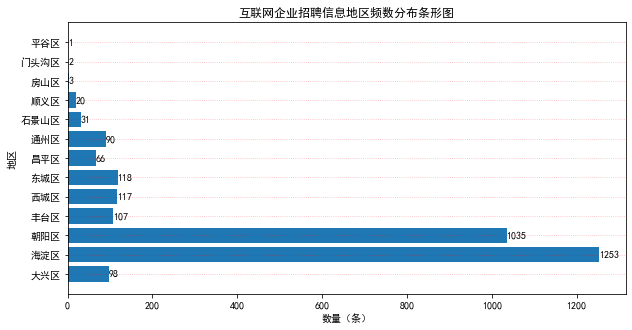

In [5]:
jp_data = pd.concat([java_data, python_data], axis = 0)
jp_data = jp_data.reset_index(drop=True)
#获取横纵坐标值
dict = {}
for i in jp_data['district']:
    if i not in dict.keys():
        dict[i] = 1
    else:
        dict[i] += 1
index = list(dict.keys())
num = []
for i in index:
    num.append(dict[i])
#设置大小
p2 = plt.figure(figsize = (10, 5))
ax2 = p2.add_subplot(1, 1, 1)
plt.sca(ax2)
b = ax2.barh(range(len(index)), num, color='#6699CC')
#添加数据标签并绘图
for rect in b:
    w = rect.get_width()
    ax2.text(w, rect.get_y()+rect.get_height()/2, '%d' % int(w), ha='left', va='center')
plt.barh(index, num)
plt.grid(True, axis="y",ls=":",color="r",alpha=0.3)
plt.xlabel("数量（条）")
plt.ylabel("地区")
plt.title("互联网企业招聘信息地区频数分布条形图")
plt.savefig("互联网企业招聘信息地区频数分布条形图.png")

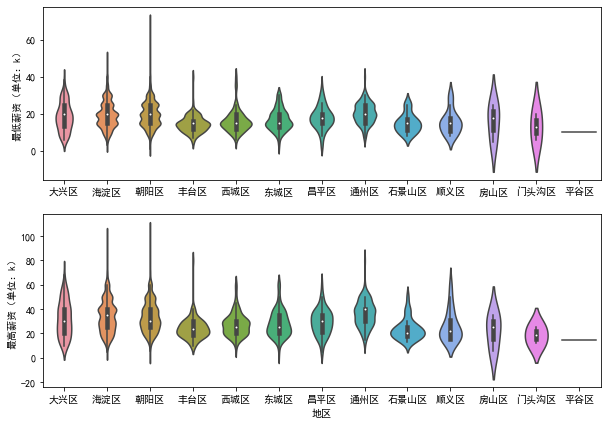

In [83]:
p3 = plt.figure(figsize = (10, 7))
ax31 = p3.add_subplot(2, 1, 1)
ax32 = p3.add_subplot(2, 1, 2)
plt.sca(ax31)
sns.violinplot(x = jp_data['district'],y = jp_data['min_salary'])
plt.xlabel("")
plt.ylabel("最低薪资（单位：k）")
plt.sca(ax32)
sns.violinplot(x = jp_data['district'],y = jp_data['max_salary']) 
plt.xlabel("地区")
plt.ylabel("最高薪资（单位：k）")
plt.savefig("互联网企业招聘信息薪资分布小提琴图.png")

In [52]:
from pyecharts import Map
columns = jp_data['district'].drop_duplicates()
columns = columns.reset_index(drop=True)
row = []
for i in range(13):
    d = columns[i]
    data = jp_data[jp_data['district'] == d]
    row.append(sum(data['min_salary'] + data['max_salary']) / 2 / data.shape[0])
map = Map("北京市Java与Python相关岗位平均薪资", width=700, height=500)
map.add("", list(columns.values), row, maptype='北京',visual_range=[0, 30], is_visualmap=True, visual_text_color='#000')
map.render('北京.html')

In [44]:
row

[25.46938775510204,
 27.0438946528332,
 27.05410628019324,
 19.401869158878505,
 21.905982905982906,
 22.673728813559322,
 23.863636363636363,
 28.516666666666666,
 19.35483870967742,
 20.925,
 19.0,
 15.75,
 12.5]

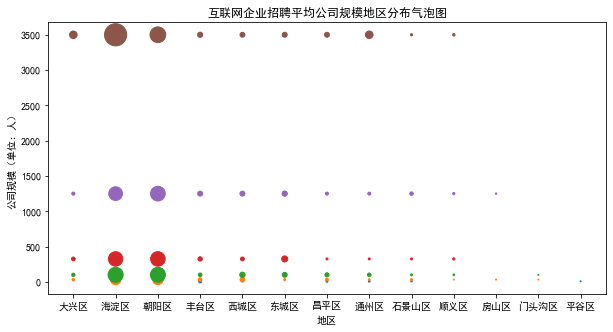

In [84]:
columns = jp_data['district'].drop_duplicates()
columns = columns.reset_index(drop=True)
row = jp_data['companySize']
row = row.drop_duplicates().sort_values().reset_index(drop=True)
arr1 = []
arr2 = []
for i in range(6):
    temp1 = []
    temp2 = []
    for j in range(13):
        s = row[i]
        d = columns[j]
        size = jp_data['companySize']
        if jp_data[(jp_data['district'] == d) & (size == s)].shape[0] != 0:
            temp1.append(1)
        else:
            temp1.append(0)
        temp2.append(jp_data[(jp_data['district'] == d) & (size == s)].shape[0])
    arr1.append(temp1)
    arr2.append(temp2)
new_df1 = pd.DataFrame(data = arr1, index = row, columns = columns)
new_df2 = pd.DataFrame(data = arr2, index = row, columns = columns)
#设置大小
p4 = plt.figure(figsize = (10, 5))
ax4 = p4.add_subplot(1, 1, 1)
plt.sca(ax4)
for i in range(len(row)):
    plt.scatter(columns, new_df1[new_df1.index == row[i]] * row[i], s = new_df2[new_df2.index == row[i]])
plt.xlabel("地区")
plt.ylabel("公司规模（单位：人）")
plt.title("互联网企业招聘平均公司规模地区分布气泡图")
plt.savefig("互联网企业招聘平均公司规模地区分布气泡图.png")

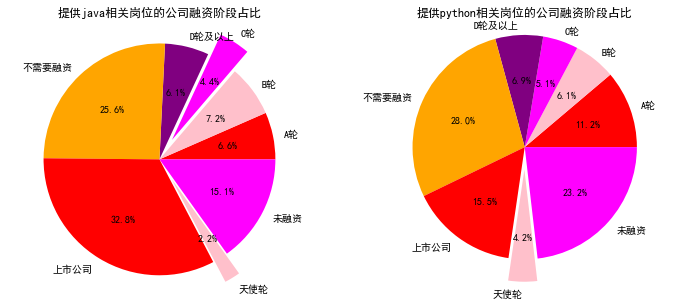

In [85]:
stage = ['A轮', 'B轮', 'C轮', 'D轮及以上', '不需要融资', '上市公司', '天使轮', '未融资']
count1 = []
count1.append(java_data[java_data['financeStage'] == 'A轮'].shape[0])
count1.append(java_data[java_data['financeStage'] == 'B轮'].shape[0])
count1.append(java_data[java_data['financeStage'] == 'C轮'].shape[0])
count1.append(java_data[java_data['financeStage'] == 'D轮及以上'].shape[0])
count1.append(java_data[java_data['financeStage'] == '不需要融资'].shape[0])
count1.append(java_data[java_data['financeStage'] == '上市公司'].shape[0])
count1.append(java_data[java_data['financeStage'] == '天使轮'].shape[0])
count1.append(java_data[java_data['financeStage'] == '未融资'].shape[0])
colors = ['red','pink','magenta','purple','orange']
explode1 =[0,0,0.2,0,0,0,0.2,0]
count2 = []
count2.append(python_data[python_data['financeStage'] == 'A轮'].shape[0])
count2.append(python_data[python_data['financeStage'] == 'B轮'].shape[0])
count2.append(python_data[python_data['financeStage'] == 'C轮'].shape[0])
count2.append(python_data[python_data['financeStage'] == 'D轮及以上'].shape[0])
count2.append(python_data[python_data['financeStage'] == '不需要融资'].shape[0])
count2.append(python_data[python_data['financeStage'] == '上市公司'].shape[0])
count2.append(python_data[python_data['financeStage'] == '天使轮'].shape[0])
count2.append(python_data[python_data['financeStage'] == '未融资'].shape[0])
explode2 =[0,0,0,0,0,0,0.2,0]

p5 = plt.figure(figsize = (12, 5))
ax51 = p5.add_subplot(1, 2, 1)
ax52 = p5.add_subplot(1, 2, 2)

plt.sca(ax51)
plt.pie(x = count1, labels=stage, explode=explode1, colors=colors, autopct = "%1.1f%%")
plt.axis("equal")
plt.title("提供java相关岗位的公司融资阶段占比")

plt.sca(ax52)
plt.pie(x = count2, labels=stage, explode=explode2, colors=colors, autopct = "%1.1f%%")
plt.axis("equal")
plt.title("提供python相关岗位的公司融资阶段占比")

plt.savefig("提供两个相关岗位的公司分别融资阶段占比饼状图.png")

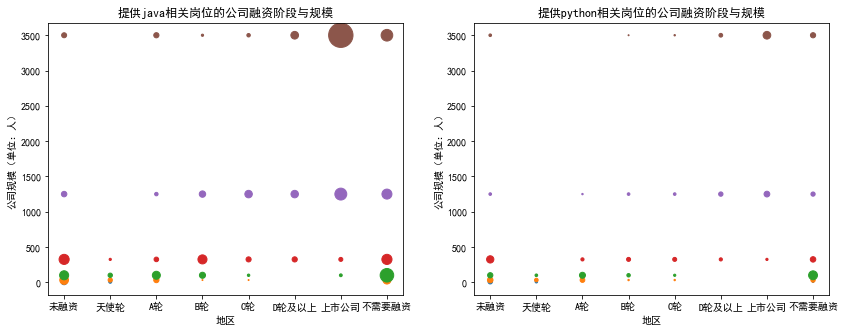

In [86]:
columns = pd.Series(['未融资', '天使轮', 'A轮', 'B轮', 'C轮', 'D轮及以上', '上市公司', '不需要融资'])
row = java_data['companySize']
row = row.drop_duplicates().sort_values().reset_index(drop=True)
arr1 = []
arr2 = []
for i in range(6):
    temp1 = []
    temp2 = []
    for j in range(8):
        s = row[i]
        d = columns[j]
        size = java_data['companySize']
        if java_data[(java_data['financeStage'] == d) & (size == s)].shape[0] != 0:
            temp1.append(1)
        else:
            temp1.append(0)
        temp2.append(java_data[(java_data['financeStage'] == d) & (size == s)].shape[0])
    arr1.append(temp1)
    arr2.append(temp2)
new_df1 = pd.DataFrame(data = arr1, index = row, columns = columns)
new_df2 = pd.DataFrame(data = arr2, index = row, columns = columns)

columns2 = columns
row2 = python_data['companySize']
row2 = row2.drop_duplicates().sort_values().reset_index(drop=True)
arr12 = []
arr22 = []
for i in range(6):
    temp12 = []
    temp22 = []
    for j in range(8):
        s2 = row2[i]
        d2 = columns2[j]
        size2 = python_data['companySize']
        if python_data[(python_data['financeStage'] == d2) & (size2 == s2)].shape[0] != 0:
            temp12.append(1)
        else:
            temp12.append(0)
        temp22.append(python_data[(python_data['financeStage'] == d2) & (size2 == s2)].shape[0])
    arr12.append(temp12)
    arr22.append(temp22)
new_df12 = pd.DataFrame(data = arr12, index = row2, columns = columns2)
new_df22 = pd.DataFrame(data = arr22, index = row2, columns = columns2)

#设置大小
p6 = plt.figure(figsize = (14, 5))
ax61 = p6.add_subplot(1, 2, 1)
ax62 = p6.add_subplot(1, 2, 2)
plt.sca(ax61)
for i in range(len(row)):
    plt.scatter(columns, new_df1[new_df1.index == row[i]] * row[i], s = new_df2[new_df2.index == row[i]])
plt.ylabel("公司规模（单位：人）")
plt.xlabel("地区")
plt.title('提供java相关岗位的公司融资阶段与规模')
plt.sca(ax62)
for i in range(len(row)):
    plt.scatter(columns2, new_df12[new_df12.index == row[i]] * row[i], s = new_df22[new_df22.index == row[i]])
plt.xlabel("地区")
plt.ylabel("公司规模（单位：人）")
plt.title('提供python相关岗位的公司融资阶段与规模')
plt.savefig("提供两个相关岗位的公司融资阶段与规模气泡图.png")

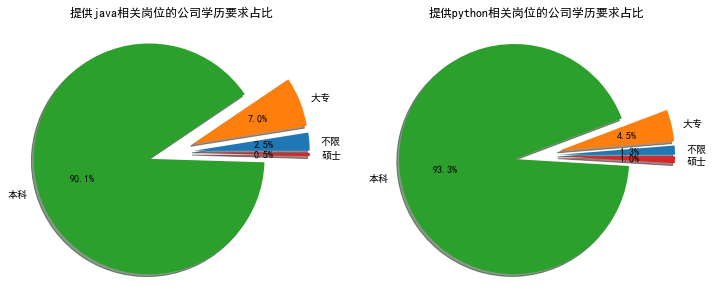

In [87]:
stage = ['不限','大专','本科','硕士']
count1 = []
count1.append(java_data[java_data['education'] == '不限'].shape[0])
count1.append(java_data[java_data['education'] == '大专'].shape[0])
count1.append(java_data[java_data['education'] == '本科'].shape[0])
count1.append(java_data[java_data['education'] == '硕士'].shape[0])
explode1 = [0.2,0.2,0.2,0.2]
count2 = []
count2.append(python_data[python_data['education'] == '不限'].shape[0])
count2.append(python_data[python_data['education'] == '大专'].shape[0])
count2.append(python_data[python_data['education'] == '本科'].shape[0])
count2.append(python_data[python_data['education'] == '硕士'].shape[0])
explode2 = [0.2,0.2,0.2,0.2]

p5 = plt.figure(figsize = (12, 5))
ax51 = p5.add_subplot(1, 2, 1)
ax52 = p5.add_subplot(1, 2, 2)

plt.sca(ax51)
plt.pie(x = count1, labels=stage, explode=explode1, shadow=True, autopct = "%1.1f%%")
plt.axis("equal")
plt.title("提供java相关岗位的公司学历要求占比")

plt.sca(ax52)
plt.pie(x = count2, labels=stage, explode=explode2, shadow=True, autopct = "%1.1f%%")
plt.axis("equal")
plt.title("提供python相关岗位的公司学历要求占比")
plt.savefig("提供两个相关岗位的公司分别学历要求占比饼状图.png")

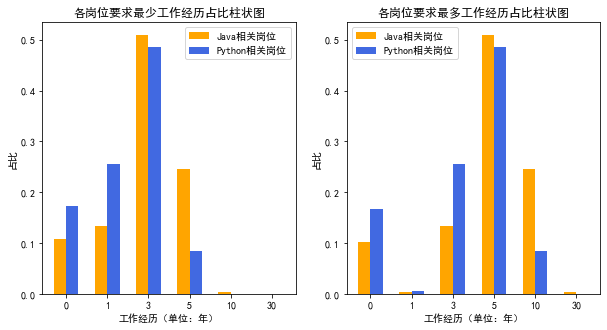

In [88]:
min_year = java_data['min_wY'].drop_duplicates().sort_values().reset_index(drop=True)
count1 = []
for i in range(len(min_year)):
    count1.append(java_data[java_data['min_wY'] == min_year[i]].shape[0])
count1.append(0)
count1 = count1 / sum(count1)

min_year2 = python_data['min_wY'].drop_duplicates().sort_values().reset_index(drop=True)
count12 = []
for i in range(len(min_year2)):
    count12.append(python_data[python_data['min_wY'] == min_year2[i]].shape[0])
count12.append(0)
count12.append(0)
count12 = count12 / sum(count12)

max_year = java_data['max_wY'].drop_duplicates().sort_values().reset_index(drop=True)
count2 = []
for i in range(len(max_year)):
    count2.append(java_data[java_data['max_wY'] == max_year[i]].shape[0])
count2 = count2 / sum(count2)

max_year2 = python_data['max_wY'].drop_duplicates().sort_values().reset_index(drop=True)
count22 = []
for i in range(len(max_year2)):
    count22.append(python_data[python_data['max_wY'] == max_year2[i]].shape[0])
count22.append(0)
count22 = count22 / sum(count22)

x_labels = [0, 1, 3, 5, 10, 30]
# 生成横坐标范围
x = np.arange(6)
p7 = plt.figure(figsize = (10, 5))
ax71 = p7.add_subplot(1, 2, 1)
ax72 = p7.add_subplot(1, 2, 2)
plt.sca(ax71)
# 生成多柱图
plt.bar(x + 0.00, count1, color='orange', width=0.3, label="Java相关岗位")
plt.bar(x + 0.30, count12, color='royalblue', width=0.3, label="Python相关岗位")
# 横坐标绑定
plt.xticks(x + 0.15, x_labels)
plt.xlabel("工作经历（单位：年）")
plt.ylabel("占比")
plt.title('各岗位要求最少工作经历占比柱状图')
# 生成图片
plt.legend()
plt.sca(ax72)
# 生成多柱图
plt.bar(x + 0.00, count2, color='orange', width=0.3, label="Java相关岗位")
plt.bar(x + 0.30, count22, color='royalblue', width=0.3, label="Python相关岗位")
# 横坐标绑定
plt.xticks(x + 0.15, x_labels)
plt.xlabel("工作经历（单位：年）")
plt.ylabel("占比")
plt.title('各岗位要求最多工作经历占比柱状图')
# 生成图片
plt.legend()
plt.savefig("提供两个相关岗位的公司分别工作经历要求占比柱状图.png")

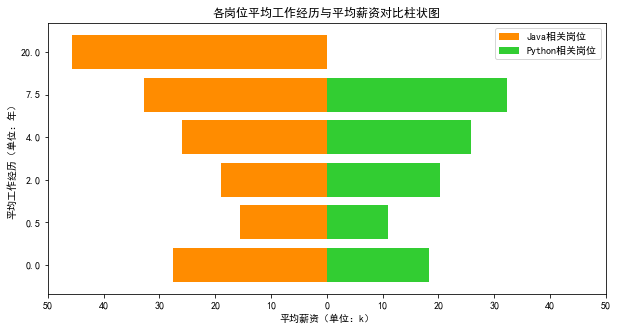

<Figure size 432x288 with 0 Axes>

In [89]:
mean_wY = [0.0, 0.5, 2.0, 4.0, 7.5, 20.0]

salary1 = []
for i in range(len(mean_wY)):
    jd = java_data[(java_data['min_wY'] + java_data['max_wY']) / 2 == mean_wY[i]]
    salary1.append(sum(jd['min_salary'] + jd['max_salary']) / 2 / jd.shape[0])
    
salary2 = []
for i in range(len(mean_wY) - 1):
    pd = python_data[(python_data['min_wY'] + python_data['max_wY']) / 2 == mean_wY[i]]
    salary2.append(sum(pd['min_salary'] + pd['max_salary']) / 2 / pd.shape[0])
salary2.append(0)

x = np.array(salary1)
y = np.array(salary2)
plt.figure(figsize=(10,5))
plt.barh(range(len(y)), -x,color='darkorange',label='Java相关岗位')
plt.barh(range(len(x)), y,color='limegreen',label='Python相关岗位')
plt.xlim((-50,50))
plt.xticks((-50,-40,-30,-20,-10,0,10,20,30,40,50),('50','40','30','20','10','0','10','20','30','40','50'))
plt.yticks((0, 1, 2, 3, 4, 5),('0.0', '0.5', '2.0', '4.0', '7.5', '20.0'))
plt.xlabel('平均薪资（单位：k）')
plt.ylabel('平均工作经历（单位：年）')
plt.legend()
plt.title('各岗位平均工作经历与平均薪资对比柱状图')
plt.show()
plt.savefig("各岗位平均工作经历与平均薪资对比柱状图.png")

Building prefix dict from D:\Users\ouyan\anaconda3\lib\site-packages\jieba\dict.txt ...
Dumping model to file cache C:\Users\ouyan\AppData\Local\Temp\jieba.cache
Loading model cost 1.4221618175506592 seconds.
Prefix dict has been built succesfully.


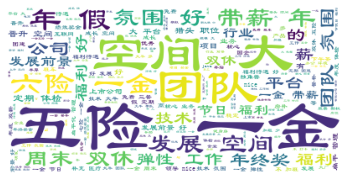

In [90]:
# 绘制词云,将职位福利中的字符串汇总  
text = ''  
for line in java_data['positionAdvantage']:  
   text += line  
# 使用jieba模块将字符串分割为单词列表
cut_text = ' '.join(jieba.cut(text))
font = r'C:\Windows\Fonts\SIMLI.TTF'
cloud = WordCloud(
    background_color = 'white',
    font_path=font,
    #mask = color_mask,
    max_words = 1000,
    max_font_size = 100
    ).generate(cut_text)

# 保存词云图片
cloud.to_file('java词云.jpg')
plt.imshow(cloud)
plt.axis('off')
plt.show()

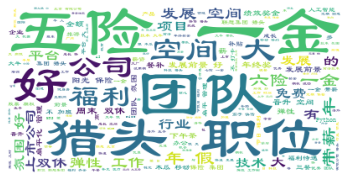

In [91]:
# 绘制词云,将职位福利中的字符串汇总  
text = ''  
for line in python_data['positionAdvantage']:  
   text += line  
# 使用jieba模块将字符串分割为单词列表
cut_text = ' '.join(jieba.cut(text))
font = r'C:\Windows\Fonts\SIMLI.TTF'
cloud = WordCloud(
    background_color = 'white',
    font_path=font,
    #mask = color_mask,
    max_words = 1000,
    max_font_size = 100
    ).generate(cut_text)

# 保存词云图片
cloud.to_file('python词云.jpg')
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [92]:
enc = OrdinalEncoder()
enc.fit(java_data.iloc[:,[1, 4]]) 
enc.categories_ = [array(['不需要融资', '未融资', '天使轮', 'A轮', 'B轮', 'C轮', 'D轮及以上', '上市公司'], dtype=object),
                   array(['不限', '大专', '本科', '硕士'], dtype=object)]
java_data.iloc[:,[1,4]] = enc.transform(java_data.iloc[:,[1,4]])
#java_data = pd.get_dummies(java_data, columns = ['district'])


enc1 = OrdinalEncoder()
enc1.fit(python_data.iloc[:,[1, 4]]) 
enc1.categories_ = [array(['不需要融资', '未融资', '天使轮', 'A轮', 'B轮', 'C轮', 'D轮及以上', '上市公司'], dtype=object),
                   array(['不限', '大专', '本科', '硕士'], dtype=object)]
python_data.iloc[:,[1,4]] = enc1.transform(python_data.iloc[:,[1,4]])
#python_data = pd.get_dummies(python_data, columns = ['district'])


In [62]:
java_data.to_csv('java_data1.csv', index=False, encoding='utf-8_sig')
python_data.to_csv('python_data1.csv', index=False, encoding='utf-8_sig')

In [25]:
java_data.to_csv('java_data1.csv', index=False, encoding='utf-8_sig')
python_data.to_csv('python_data1.csv', index=False, encoding='utf-8_sig')

In [68]:
java_data = pd.read_csv('./java_data1.csv')
python_data = pd.read_csv('./python_data1.csv')
java_data = java_data.drop('companyShortName', axis = 1)
java_data = java_data.drop('positionName', axis = 1)
java_data = java_data.drop('positionAdvantage', axis = 1)

python_data = python_data.drop('companyShortName', axis = 1)
python_data = python_data.drop('positionName', axis = 1)
python_data = python_data.drop('positionAdvantage', axis = 1)

In [72]:
def StandardScaler(data): 
    data=(data - data.mean()) / data.std() 
    return data

In [77]:
java_data1 = StandardScaler(java_data.iloc[:, [i for i in range(4)] + [i for i in range(6, 8)]])
java_data1['min_salary'] = java_data['min_salary']
java_data1['max_salary'] = java_data['max_salary']
java_data = java_data1
python_data1 = StandardScaler(python_data.iloc[:, [i for i in range(4)] + [i for i in range(6, 8)]])
python_data1['min_salary'] = python_data['min_salary']
python_data1['max_salary'] = python_data['max_salary']
python_data = python_data1

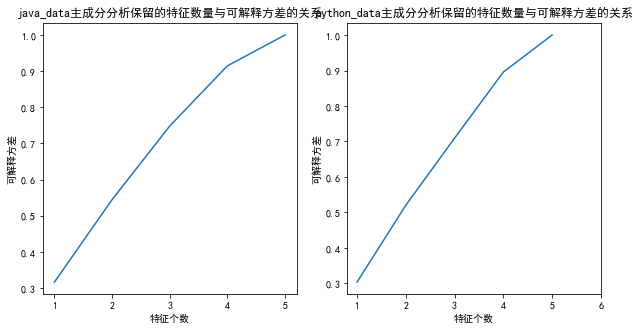

In [19]:
from sklearn import decomposition
p9 = plt.figure(figsize = (10, 5))
ax91 = p9.add_subplot(1, 2, 1)
ax92 = p9.add_subplot(1, 2, 2)
plt.sca(ax91)
pca = decomposition.PCA()
j = java_data.iloc[:,[i for i in range(4)] + [6]]
pca.fit(j)
ratio=pca.explained_variance_ratio_
plt.plot([i for i in range(j.shape[1])], [np.sum(ratio[:i+1]) for i in range(j.shape[1])])
plt.xlabel("特征个数")
plt.ylabel("可解释方差")
plt.xticks((0,1,2,3,4),('1','2','3','4','5'))
plt.title('java_data主成分分析保留的特征数量与可解释方差的关系')
plt.sca(ax92)
p = python_data.iloc[:,[i for i in range(4)] + [6]]
pca.fit(p)
ratio=pca.explained_variance_ratio_
plt.plot([i for i in range(p.shape[1])], [np.sum(ratio[:i+1]) for i in range(p.shape[1])])
plt.xlabel("特征个数")
plt.ylabel("可解释方差")
plt.xticks((0,1,2,3,4,5),('1','2','3','4','5','6'))
plt.title('python_data主成分分析保留的特征数量与可解释方差的关系')
plt.savefig("主成分分析保留的特征数量与可解释方差的关系.png")

In [66]:
#合并两个wY
java_data['workYear'] = (java_data['min_wY'] + java_data['max_wY']) / 2
java_data = java_data.drop(['min_wY', 'max_wY'], axis = 1)
#合并两个wY
python_data['workYear'] = (python_data['min_wY'] + python_data['max_wY']) / 2
python_data = python_data.drop(['min_wY', 'max_wY'], axis = 1)

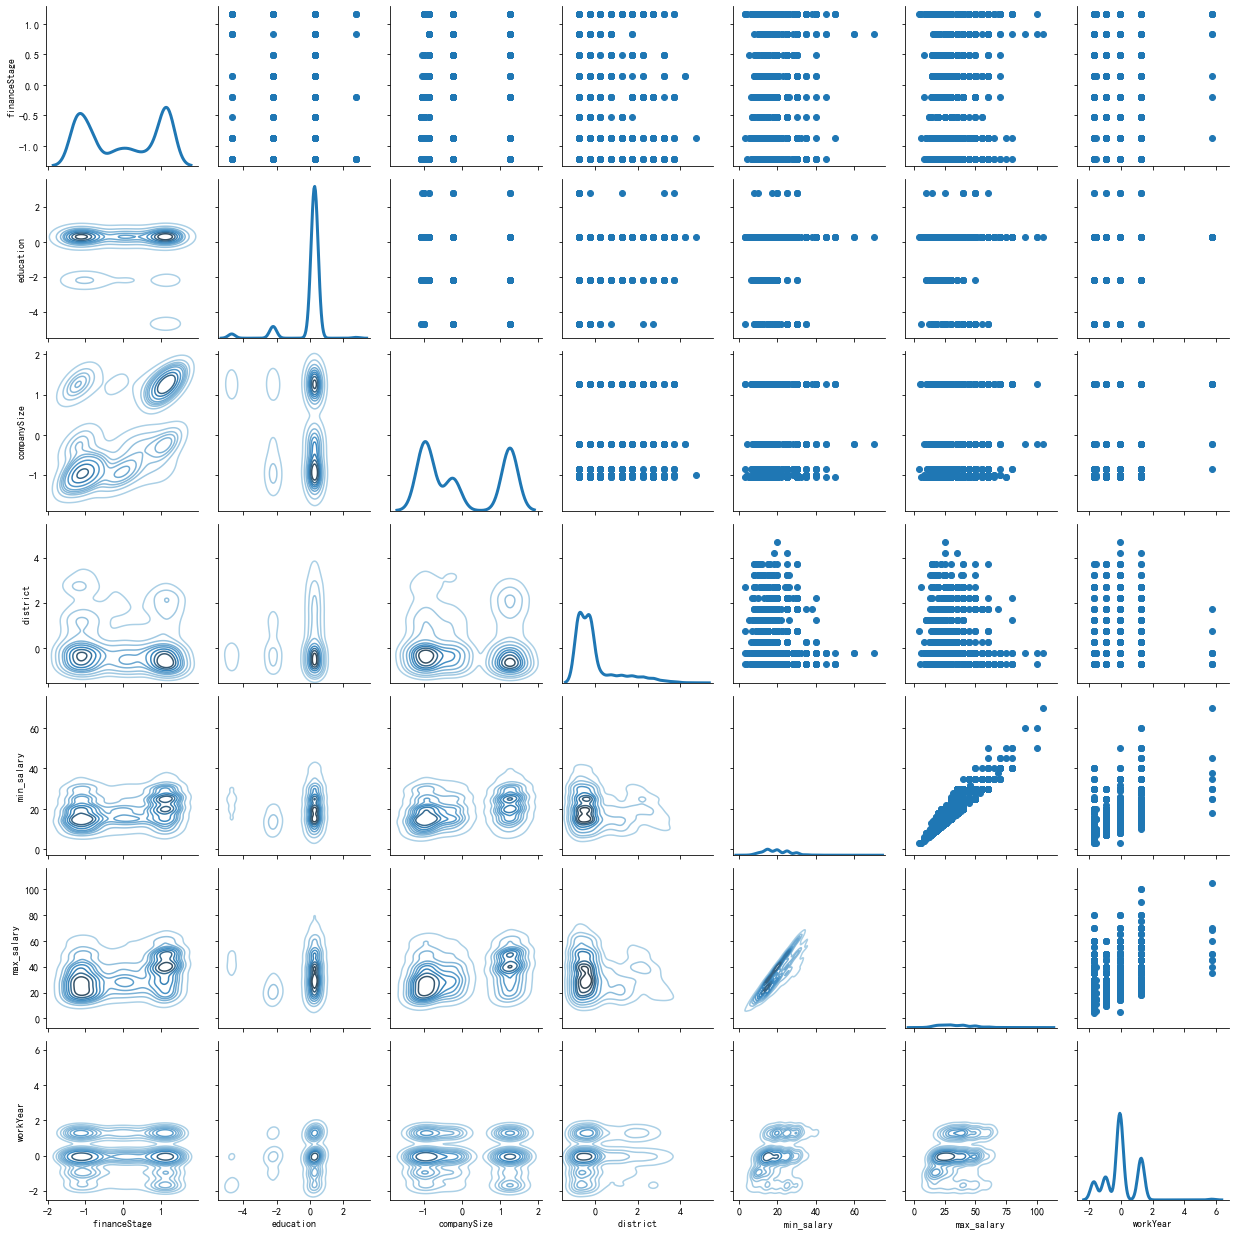

In [160]:
g6 = sns.PairGrid(java_data)
g6 = g6.map_upper(plt.scatter)
g6 = g6.map_lower(sns.kdeplot, cmap="Blues_d")
g6 = g6.map_diag(sns.kdeplot, lw=3, legend=False)

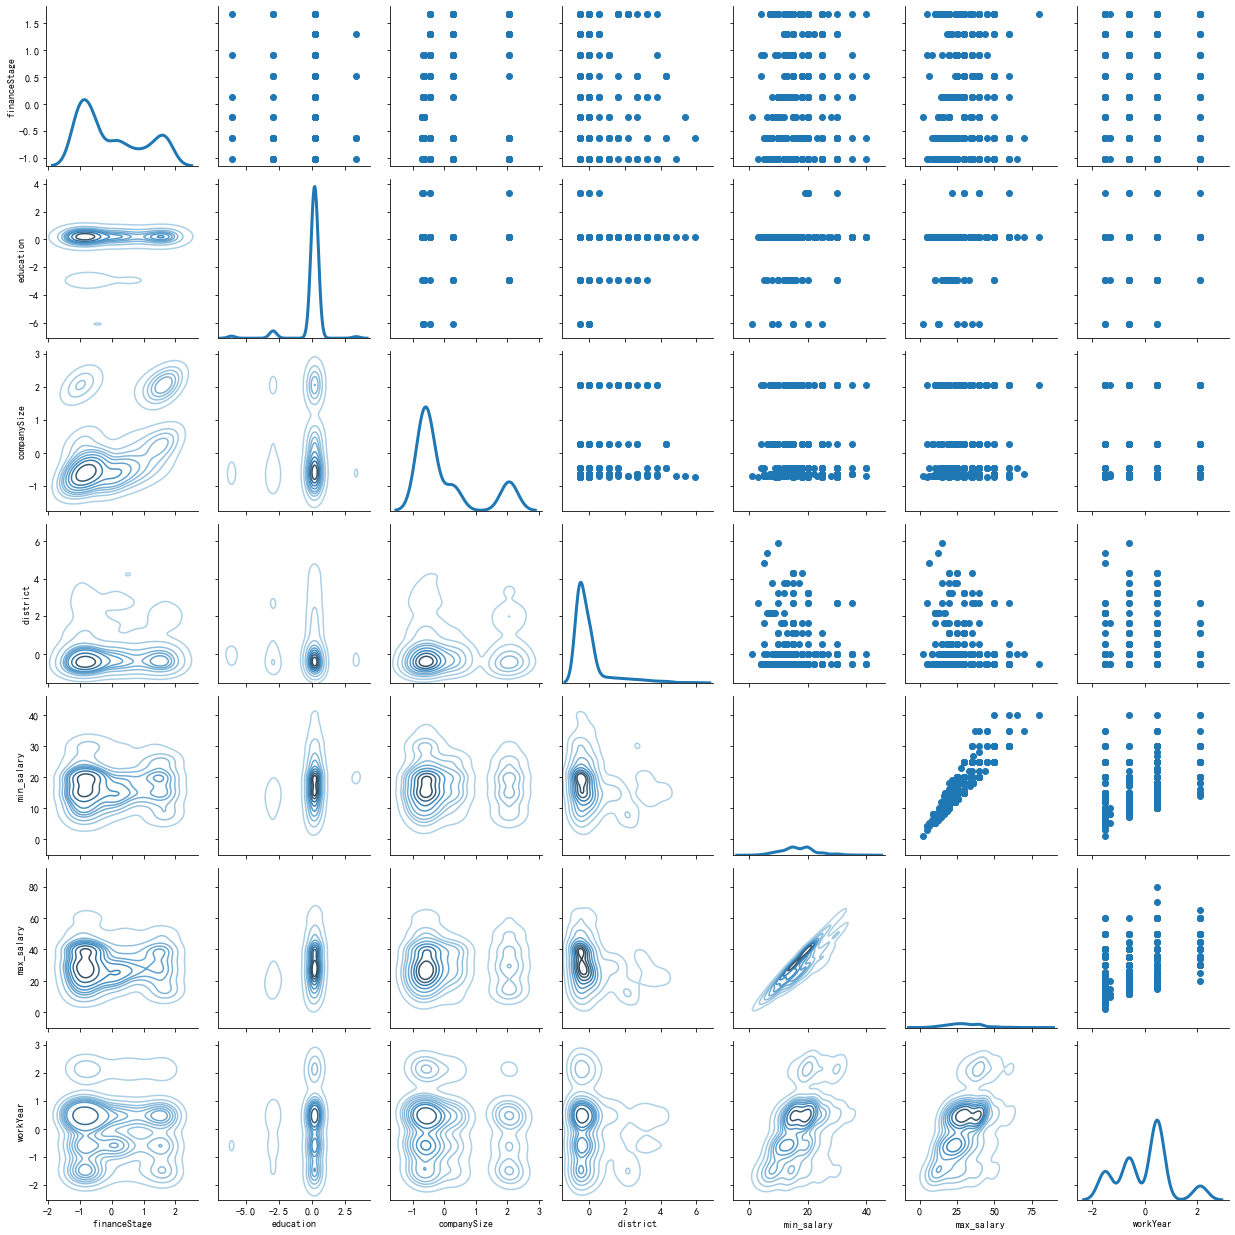

In [183]:
g7 = sns.PairGrid(python_data)
g7 = g7.map_upper(plt.scatter)
g7 = g7.map_lower(sns.kdeplot, cmap="Blues_d")
g7 = g7.map_diag(sns.kdeplot, lw=3, legend=False)

<AxesSubplot:>

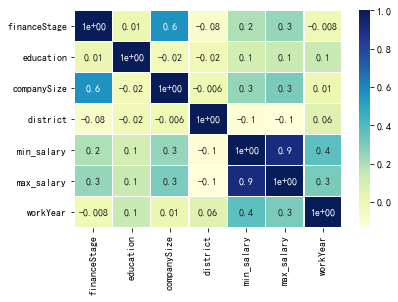

In [182]:
sns.heatmap(java_data.corr(), annot=True, fmt="0.001", linewidths=.5, cmap="YlGnBu")

<AxesSubplot:>

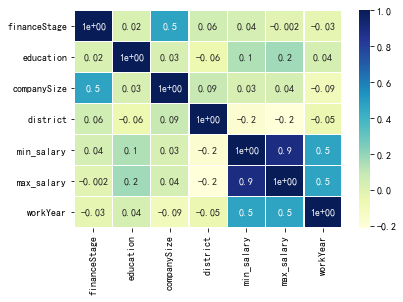

In [184]:
sns.heatmap(python_data.corr(), annot=True, fmt="0.001", linewidths=.5, cmap="YlGnBu")

In [70]:
java_data = pd.read_csv('./java_data1.csv')
python_data = pd.read_csv('./python_data1.csv')

In [32]:
mean_salary = (java_data['min_salary'] + java_data['max_salary']) / 2
offset = mean_salary - java_data['min_salary']
java_data = java_data.drop(['min_salary', 'max_salary'], axis = 1)
java_data['mean_salary'] = mean_salary
java_data['offset'] = offset

In [38]:
mean_salary = (python_data['min_salary'] + python_data['max_salary']) / 2
offset = mean_salary - python_data['min_salary']
python_data = python_data.drop(['min_salary', 'max_salary'], axis = 1)
python_data['mean_salary'] = mean_salary
python_data['offset'] = offset

KeyError: 'min_salary'

In [74]:
import pandas as pd
import numpy as np
java_data = pd.read_csv('./java_data1.csv')
python_data = pd.read_csv('./python_data1.csv')

def labelcount_encode(X, categorical_features, ascending=False):
    print('LabelCount encoding: {}'.format(categorical_features))
    X_ = pd.DataFrame()
    for cat_feature in categorical_features:
        cat_feature_value_counts = X[cat_feature].value_counts()
        value_counts_list = cat_feature_value_counts.index.tolist()
        if ascending:
            # 升序
            value_counts_range = list(
                reversed(range(len(cat_feature_value_counts))))
        else:
            # 降序
            value_counts_range = list(range(len(cat_feature_value_counts)))
            print(value_counts_list)
            print(value_counts_range)
            print(zip(value_counts_list, value_counts_range))
        labelcount_dict = dict(zip(value_counts_list, value_counts_range))
        X_[cat_feature] = X[cat_feature].map(labelcount_dict)
    X_ = X_.add_suffix('_labelcount_encoded')
    if ascending:
        X_ = X_.add_suffix('_ascending')
    else:
        X_ = X_.add_suffix('_descending')
    X_ = X_.astype(np.uint32)
    return X_

,financeStage,education,min_salary,max_salary,companySize,workYear,district
0,7.0,2.0,20,40,3500.0,7.5,5
1,0.0,2.0,20,35,3500.0,4.0,0
2,7.0,2.0,25,50,3500.0,4.0,1
3,6.0,2.0,15,30,1250.0,7.5,1
4,1.0,2.0,9,18,3500.0,2.0,4


In [ ]:
j = labelcount_encode(java_data, ['district'])
p = labelcount_encode(python_data, ['district'])

In [ ]:
java_data = java_data.drop(['district'], axis = 1)
python_data = python_data.drop(['district'], axis = 1)

java_data['district'] = j
python_data['district'] = p

In [ ]:
java_data.to_csv('java_data1.csv', index=False, encoding='utf-8_sig')
python_data.to_csv('python_data1.csv', index=False, encoding='utf-8_sig')